# Deterministic Linear Transport equation, unsplit
---
Consider the equation
$$
\epsilon \frac{\partial f}{\partial t} + v\frac{\partial f}{\partial x} = \frac{\sigma(x, z)}{\epsilon}\left(\frac{1}{2}\int_{-1}^{1}f(x, t, v')dv' - f(x, t, v)\right),
$$
where $\epsilon$ is a small number, $v \in [-1, 1]$.

It seems to me that $v$ follows a uniform distribution (as Gauss-Legendre quadrature is used to compute the integral).

We let $\sigma(x, z) \equiv 1$.

BC: for all $t$,
$$
\begin{aligned}
&f(0, t, v) = 1, \quad v > 0, \\
&f(1, t, v) = 0, \quad v < 0, \\
\end{aligned}
$$


The spatiotemporal domain is 
$$
(x, t, v) \in [0, 1]\times [0, 0.01] \times [0, 1].
$$

In [1]:
NAME = "3_1e-4_unsplit"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [3] + [32]*4 + [1] # (x, t, v) -> (f)
c0 = 1.0
w0 = jnp.array([[1.0, 1.0, 1.0]]).T
w1 = jnp.array([[1.0]]) # (w_r, w_j)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)

domain = jnp.array([[0., 0., -1.0], [1., 0.01, 1.0]])

sigma = 1.0
epsilon = 1e-4

@jax.jit
def model(params, xtv): # for predictions
	# linear scaling -> must be combined with scaling in quadrature nodes
	xtv = (2*xtv - (domain[0, :]+domain[1, :]))/(domain[1, :] - domain[0, :])
	for w, b in params[:-1]:
		xtv = jnp.sin(jnp.dot(xtv, w) + b)
	return jnp.dot(xtv, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
# f_c = model(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
# df_dxtv_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
# df_dx_c, df_dt_c = df_dxtv_c[:, 0:1, 0], df_dxtv_c[:, 0:1, 1]

In [5]:
metaloss = mae

# static_jit = lambda i: jax.partial(jax.jit, static_argnums = i)

@jax.jit
def quadrature(params, x, t, v, w):
	xt_ = jnp.repeat(jnp.hstack([x, t]), w.shape[0], axis = 0)
	v_ = jnp.tile(v, (x.shape[0], 1))
	f = model(params, jnp.hstack([xt_, v_])).reshape((x.shape[0], w.shape[0]))
	return jnp.dot(f, w)

# jacobian[i] = [[df/dx, df/dt, df/dv]]
# i: the i^th input

# hessian[i] = [
#				[[du/dxx, du/dxy],
#                [du/dxy, du/dyy]],
#               [[dv/dxx, dv/dxy],
#                [dv/dxy, dv/dyy]]
#              ]
@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, bc, quad = batch["collocation"], batch["dirichlet"], batch["bc"], batch["quad"]
	direct_params = params
	
	if collocation[0] is not None:
		f_c = model(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
		df_dxtv_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
		df_dx_c, df_dt_c = df_dxtv_c[:, 0:1, 0], df_dxtv_c[:, 0:1, 1]
		
		# quad.w: [q, 1]
		# quad.v: [q, 1]
		f_int = quadrature(direct_params, collocation.x, collocation.t, quad.v, quad.w)
		loss_c = metaloss(epsilon**2*df_dt_c + epsilon*collocation.v*df_dx_c, sigma*(0.5*f_int - f_c))
	else:
		loss_c = 0
        
	if dirichlet[0] is not None:
		f_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t, dirichlet.v]))
		loss_d = metaloss(f_d, dirichlet.f)
	else:
		loss_d = 0.0
		
	if bc[0] is not None:
		f_bl = model(direct_params, jnp.hstack([bc.l, bc.t, bc.v]))
		f_br = model(direct_params, jnp.hstack([bc.r, bc.t, -bc.v]))
		loss_bl = metaloss(f_bl, bc.fl) 
		loss_br = metaloss(f_br, bc.fr)
	else:
		loss_bl = loss_br = 0.0
		
	return loss_c, loss_d, loss_bl, loss_br

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_bl, loss_br = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + w["bl"]*loss_bl + w["br"]*loss_br + \
			l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_bl, loss_br = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c"]*loss_c + w["d"]*loss_d + w["bl"]*loss_bl + w["br"]*loss_br, \
			loss_c, loss_d, loss_bl, loss_br, l1, l2

In [6]:
key, *subkeys = random.split(key, 3)

n_quad = 32
v_quad, w_quad = np.polynomial.legendre.leggauss(n_quad)
v_quad = jnp.array(v_quad, dtype = jnp.float32).reshape((-1, 1))
w_quad = jnp.array(w_quad, dtype = jnp.float32).reshape((-1, 1))
v_pos = v_quad[jnp.where(v_quad > 0)]


f_l_fn = lambda x, t, v: jnp.ones_like(x)
f_r_fn = lambda x, t, v: jnp.zeros_like(x)
n_b = 100
t_b = jnp.linspace(*domain[:, 1], n_b)
# v_b = jnp.linspace(*domain[:, 2], n_b)
v_b = v_pos
tv_b = tensor_grid([t_b, v_b])
t_b, v_b = tv_b[:, 0:1], tv_b[:, 1:2]
x_bl = jnp.ones_like(t_b)*domain[0, 0]
x_br = jnp.ones_like(t_b)*domain[1, 0]
f_bl = f_l_fn(x_bl, t_b, v_b)
f_br = f_r_fn(x_br, t_b, -v_b)

n_cx = 201
n_ct = 100
# x_c1 = jnp.array([[0.0]])
# x_c2 = 2**jnp.linspace(-10, 0, n_cx).reshape((-1, 1))
# x_c = jnp.vstack([x_c1, x_c2])
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
t_c = jnp.linspace(*domain[:, 1], n_ct).reshape((-1, 1))
# v_c = jnp.linspace(*domain[:, 2], n_cv).reshape((-1, 1))
v_c = v_quad
xtv_c = tensor_grid([x_c, t_c, v_c])

f_i_fn = lambda x, t, v: jnp.select([jnp.isclose(x, domain[0, 0]), x > 0], [1.0, 0.0])
n_i = 100
x_i = jnp.linspace(*domain[:, 0], n_i).reshape((-1, 1))
v_i = v_pos
xv_i = tensor_grid([x_i, v_i])
x_i, v_i = xv_i[:, 0:1], xv_i[:, 1:2]
t_i = jnp.zeros_like(x_i)
f_i = f_i_fn(x_i, t_i, v_i)


dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "v", "f"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t", "v"])
dataset_Quad = namedtuple("dataset_Quad", ["w", "v"])
dataset_BC = namedtuple("dataset_BC", ["l", "r", "t", "v", "fl", "fr"])

dirichlet = dataset_Dirichlet(x_i, t_i, v_i, f_i)
collocation = dataset_Collocation(xtv_c[:, 0:1], xtv_c[:, 1:2], xtv_c[:, 2:3])
quad = dataset_Quad(w_quad, v_quad)
bc = dataset_BC(x_bl, x_br, t_b, v_b, f_bl, f_br)

In [7]:
# class Time_Marching_Generator:
# 	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every, count1 = 0):
# 		self.key = key
# 		self.spatial_points = spatial_points
# 		self.domain = temporal_domain
# 		self.batch_size = batch_size
# 		self.iterations = iterations
# 		self._count1 = count1
# 		self._count2 = update_every
# 		if count1 < iterations:
# 			self._update(self.domain[0])
# 		else:
# 			self._update(self.domain[1])
# 		self.update_every = update_every
		
# 	def _update(self, tmax):
# 		self.key, subkey = random.split(self.key)
# 		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
# 	def __iter__(self):
# 		return self
	
# 	def __next__(self):
# 		if self._count2 == self.update_every:
# 			self._count1 = max(self.iterations, self._count1 + 1)
# 			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
# 			self._update(tmax)
# 			self._count2 = 0
# 		else:
# 			self._count2 += 1
# 		return self.spatial_points, self._t

In [8]:
lr = 1e-3
params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

batch_size = {"dirichlet": 1600, "collocation": 20200, "bc": 12800}
key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
BC = Batch_Generator(subkeys[2], bc, batch_size["bc"])

start_iteration = 0
iterations = 100000
print_every = 200
save_every = 100000
weights = {"c": 1e4, "d": 1.0, "bl": 1.0, "br": 1.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	b = next(BC)
	c = next(Collocation)
	d = next(Dirichlet)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"collocation": dataset_Collocation(jnp.vstack([b[0], c[0], d[0]]), jnp.vstack([b[1], c[1], d[1]]), jnp.vstack([b[2], c[2], d[2]])),
		"bc": dataset_BC(*b),
		"quad": quad,
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "bl", "br", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
# 			"dirichlet": dataset_Dirichlet(None, None, None, None),
			"collocation": batch["collocation"],
			"bc": batch["bc"],
			"quad": quad,
			"weights": weights,
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/27, 11:57:06, Iteration: 0, Train Loss: 1.2842e+02, c: 1.2740e-02, d: 3.0140e-02, bl: 9.4219e-01, br: 4.7328e-02, l1_reg: 2.9965e+02, l2_reg: 4.2408e+01
2020/08/27, 11:57:16, Iteration: 200, Train Loss: 3.8726e+00, c: 2.8804e-04, d: 2.4606e-02, bl: 9.6716e-01, br: 4.7968e-04, l1_reg: 2.9796e+02, l2_reg: 4.2102e+01
2020/08/27, 11:57:20, Iteration: 400, Train Loss: 2.5219e+00, c: 1.5256e-04, d: 2.0138e-02, bl: 9.7537e-01, br: 7.5247e-04, l1_reg: 2.9747e+02, l2_reg: 4.2068e+01
2020/08/27, 11:57:25, Iteration: 600, Train Loss: 1.9027e+00, c: 9.0323e-05, d: 1.7308e-02, bl: 9.8123e-01, br: 9.0327e-04, l1_reg: 2.9715e+02, l2_reg: 4.2061e+01
2020/08/27, 11:57:29, Iteration: 800, Train Loss: 1.5603e+00, c: 5.5829e-05, d: 1.5393e-02, bl: 9.8576e-01, br: 8.2533e-04, l1_reg: 2.9696e+02, l2_reg: 4.2064e+01
2020/08/27, 11:57:33, Iteration: 1000, Train Loss: 1.4970e+00, c: 4.9321e-05, d: 1.4055e-02, bl: 9.8913e-01, br: 6.3047e-04, l1_reg: 2.9680e+02, l2_reg: 4.2063e+01
2020/08/27, 11:57:38, I

2020/08/27, 12:00:54, Iteration: 10000, Train Loss: 1.0138e+00, c: 3.1351e-07, d: 1.1550e-02, bl: 9.9786e-01, br: 1.2920e-03, l1_reg: 2.7595e+02, l2_reg: 3.8081e+01
2020/08/27, 12:00:58, Iteration: 10200, Train Loss: 1.0152e+00, c: 5.3930e-07, d: 1.0286e-02, bl: 9.9914e-01, br: 3.4138e-04, l1_reg: 2.7585e+02, l2_reg: 3.8058e+01
2020/08/27, 12:01:02, Iteration: 10400, Train Loss: 1.0136e+00, c: 2.8679e-07, d: 1.1296e-02, bl: 9.9838e-01, br: 1.1046e-03, l1_reg: 2.7570e+02, l2_reg: 3.8026e+01
2020/08/27, 12:01:07, Iteration: 10600, Train Loss: 1.0234e+00, c: 1.1633e-06, d: 1.1916e-02, bl: 9.9796e-01, br: 1.8789e-03, l1_reg: 2.7559e+02, l2_reg: 3.8003e+01
2020/08/27, 12:01:11, Iteration: 10800, Train Loss: 1.0145e+00, c: 4.5007e-07, d: 1.0292e-02, bl: 9.9927e-01, br: 4.4110e-04, l1_reg: 2.7543e+02, l2_reg: 3.7965e+01
2020/08/27, 12:01:16, Iteration: 11000, Train Loss: 1.0117e+00, c: 1.9511e-07, d: 1.0208e-02, bl: 9.9932e-01, br: 1.7646e-04, l1_reg: 2.7532e+02, l2_reg: 3.7947e+01
2020/08/27

2020/08/27, 12:04:37, Iteration: 20000, Train Loss: 1.0109e+00, c: 1.1302e-07, d: 1.0400e-02, bl: 9.9908e-01, br: 3.3706e-04, l1_reg: 2.2084e+02, l2_reg: 3.5250e+01
2020/08/27, 12:04:42, Iteration: 20200, Train Loss: 1.0105e+00, c: 8.1106e-08, d: 1.0125e-02, bl: 9.9943e-01, br: 1.4811e-04, l1_reg: 2.1968e+02, l2_reg: 3.5705e+01
2020/08/27, 12:04:46, Iteration: 20400, Train Loss: 1.0123e+00, c: 3.3938e-07, d: 1.0610e-02, bl: 9.9787e-01, br: 3.8935e-04, l1_reg: 2.1837e+02, l2_reg: 3.6066e+01
2020/08/27, 12:04:50, Iteration: 20600, Train Loss: 1.0107e+00, c: 1.3597e-07, d: 1.0296e-02, bl: 9.9874e-01, br: 3.2990e-04, l1_reg: 2.1783e+02, l2_reg: 3.6640e+01
2020/08/27, 12:04:55, Iteration: 20800, Train Loss: 1.0115e+00, c: 9.8073e-08, d: 1.1128e-02, bl: 9.9834e-01, br: 1.0951e-03, l1_reg: 2.1663e+02, l2_reg: 3.7060e+01
2020/08/27, 12:04:59, Iteration: 21000, Train Loss: 1.0114e+00, c: 1.8997e-07, d: 1.0198e-02, bl: 9.9907e-01, br: 2.4715e-04, l1_reg: 2.1626e+02, l2_reg: 3.7717e+01
2020/08/27

2020/08/27, 12:08:56, Iteration: 31600, Train Loss: 2.3023e-01, c: 2.1677e-05, d: 9.1928e-03, bl: 1.7607e-03, br: 2.5106e-03, l1_reg: 3.3954e+02, l2_reg: 2.4315e+02
2020/08/27, 12:09:00, Iteration: 31800, Train Loss: 2.4369e-01, c: 2.2418e-05, d: 1.0737e-02, bl: 3.5632e-03, br: 5.2096e-03, l1_reg: 3.4071e+02, l2_reg: 2.4955e+02
2020/08/27, 12:09:05, Iteration: 32000, Train Loss: 4.4150e-02, c: 3.2798e-06, d: 6.9780e-03, bl: 3.0405e-03, br: 1.3335e-03, l1_reg: 3.4121e+02, l2_reg: 2.5720e+02
2020/08/27, 12:09:09, Iteration: 32200, Train Loss: 7.6975e-02, c: 6.9272e-06, d: 5.6353e-03, bl: 1.7620e-03, br: 3.0587e-04, l1_reg: 3.4210e+02, l2_reg: 2.6140e+02
2020/08/27, 12:09:14, Iteration: 32400, Train Loss: 3.2881e-01, c: 3.2075e-05, d: 5.8966e-03, bl: 1.7536e-03, br: 4.0397e-04, l1_reg: 3.4291e+02, l2_reg: 2.6714e+02
2020/08/27, 12:09:18, Iteration: 32600, Train Loss: 3.6527e-01, c: 3.5394e-05, d: 7.1619e-03, bl: 3.3266e-03, br: 8.3912e-04, l1_reg: 3.4371e+02, l2_reg: 2.7373e+02
2020/08/27

2020/08/27, 12:12:39, Iteration: 41600, Train Loss: 9.3981e-02, c: 9.0084e-06, d: 6.1427e-04, bl: 2.5724e-03, br: 7.1037e-04, l1_reg: 3.8338e+02, l2_reg: 4.3884e+02
2020/08/27, 12:12:43, Iteration: 41800, Train Loss: 5.9589e-02, c: 5.6782e-06, d: 9.8314e-04, bl: 1.0508e-03, br: 7.7288e-04, l1_reg: 3.8470e+02, l2_reg: 4.4560e+02
2020/08/27, 12:12:47, Iteration: 42000, Train Loss: 4.0474e-02, c: 3.6043e-06, d: 7.2121e-04, bl: 3.1637e-03, br: 5.4585e-04, l1_reg: 3.8476e+02, l2_reg: 4.4787e+02
2020/08/27, 12:12:52, Iteration: 42200, Train Loss: 3.9966e-02, c: 3.5588e-06, d: 1.4983e-03, bl: 1.0830e-03, br: 1.7962e-03, l1_reg: 3.8589e+02, l2_reg: 4.5404e+02
2020/08/27, 12:12:56, Iteration: 42400, Train Loss: 8.4624e-02, c: 8.2809e-06, d: 4.8240e-04, bl: 7.8740e-04, br: 5.4489e-04, l1_reg: 3.8609e+02, l2_reg: 4.5689e+02
2020/08/27, 12:13:01, Iteration: 42600, Train Loss: 3.2490e-02, c: 2.7330e-06, d: 1.2171e-03, bl: 2.7191e-03, br: 1.2242e-03, l1_reg: 3.8760e+02, l2_reg: 4.6384e+02
2020/08/27

2020/08/27, 12:16:21, Iteration: 51600, Train Loss: 4.2155e-03, c: 2.5141e-07, d: 7.0826e-04, bl: 4.4064e-04, br: 5.5244e-04, l1_reg: 4.2605e+02, l2_reg: 5.7030e+02
2020/08/27, 12:16:25, Iteration: 51800, Train Loss: 5.2333e-03, c: 2.1058e-07, d: 1.2010e-03, bl: 6.5852e-04, br: 1.2680e-03, l1_reg: 4.2612e+02, l2_reg: 5.7083e+02
2020/08/27, 12:16:29, Iteration: 52000, Train Loss: 5.2649e-03, c: 1.8528e-07, d: 1.1772e-03, bl: 1.3112e-03, br: 9.2373e-04, l1_reg: 4.2617e+02, l2_reg: 5.7118e+02
2020/08/27, 12:16:34, Iteration: 52200, Train Loss: 6.8660e-03, c: 1.6158e-07, d: 8.0502e-04, bl: 3.7650e-03, br: 6.8028e-04, l1_reg: 4.2623e+02, l2_reg: 5.7146e+02
2020/08/27, 12:16:38, Iteration: 52400, Train Loss: 3.4694e-03, c: 1.2445e-07, d: 7.4630e-04, bl: 6.5375e-04, br: 8.2491e-04, l1_reg: 4.2623e+02, l2_reg: 5.7167e+02
2020/08/27, 12:16:43, Iteration: 52600, Train Loss: 5.6151e-03, c: 1.4657e-07, d: 3.3158e-04, bl: 3.7139e-03, br: 1.0388e-04, l1_reg: 4.2633e+02, l2_reg: 5.7184e+02
2020/08/27

2020/08/27, 12:20:03, Iteration: 61600, Train Loss: 3.3727e-03, c: 1.0965e-07, d: 1.1660e-03, bl: 5.1971e-04, br: 5.9052e-04, l1_reg: 4.2166e+02, l2_reg: 5.7681e+02
2020/08/27, 12:20:07, Iteration: 61800, Train Loss: 8.1625e-03, c: 1.7924e-07, d: 2.4095e-03, bl: 1.9635e-03, br: 1.9972e-03, l1_reg: 4.2147e+02, l2_reg: 5.7683e+02
2020/08/27, 12:20:12, Iteration: 62000, Train Loss: 3.0765e-03, c: 1.0182e-07, d: 4.6942e-04, bl: 1.4320e-03, br: 1.5693e-04, l1_reg: 4.2144e+02, l2_reg: 5.7692e+02
2020/08/27, 12:20:16, Iteration: 62200, Train Loss: 1.9725e-03, c: 1.2426e-07, d: 1.4441e-04, bl: 5.2793e-04, br: 5.7567e-05, l1_reg: 4.2138e+02, l2_reg: 5.7699e+02
2020/08/27, 12:20:21, Iteration: 62400, Train Loss: 8.0360e-03, c: 2.4043e-07, d: 2.5501e-03, bl: 1.9075e-03, br: 1.1741e-03, l1_reg: 4.2129e+02, l2_reg: 5.7701e+02
2020/08/27, 12:20:25, Iteration: 62600, Train Loss: 2.6017e-03, c: 1.1287e-07, d: 6.0696e-04, bl: 1.1976e-04, br: 7.4629e-04, l1_reg: 4.2126e+02, l2_reg: 5.7715e+02
2020/08/27

2020/08/27, 12:23:46, Iteration: 71600, Train Loss: 5.9187e-03, c: 9.5034e-08, d: 1.3900e-03, bl: 2.5374e-03, br: 1.0410e-03, l1_reg: 4.1657e+02, l2_reg: 5.8740e+02
2020/08/27, 12:23:50, Iteration: 71800, Train Loss: 2.3400e-03, c: 8.3697e-08, d: 8.5847e-05, bl: 1.3951e-03, br: 2.2058e-05, l1_reg: 4.1639e+02, l2_reg: 5.8725e+02
2020/08/27, 12:23:54, Iteration: 72000, Train Loss: 3.2032e-03, c: 7.6157e-08, d: 1.0078e-03, bl: 4.6010e-04, br: 9.7372e-04, l1_reg: 4.1633e+02, l2_reg: 5.8714e+02
2020/08/27, 12:23:59, Iteration: 72200, Train Loss: 2.9881e-03, c: 7.7463e-08, d: 8.7401e-04, bl: 6.0958e-04, br: 7.2988e-04, l1_reg: 4.1635e+02, l2_reg: 5.8710e+02
2020/08/27, 12:24:03, Iteration: 72400, Train Loss: 2.5501e-03, c: 8.4479e-08, d: 5.7464e-04, bl: 9.7618e-04, br: 1.5452e-04, l1_reg: 4.1610e+02, l2_reg: 5.8700e+02
2020/08/27, 12:24:08, Iteration: 72600, Train Loss: 9.8136e-03, c: 1.3449e-07, d: 3.2953e-03, bl: 2.5155e-03, br: 2.6579e-03, l1_reg: 4.1627e+02, l2_reg: 5.8710e+02
2020/08/27

2020/08/27, 12:27:28, Iteration: 81600, Train Loss: 2.2350e-03, c: 8.6843e-08, d: 6.3571e-04, bl: 1.6023e-04, br: 5.7065e-04, l1_reg: 4.1021e+02, l2_reg: 5.9392e+02
2020/08/27, 12:27:32, Iteration: 81800, Train Loss: 5.8951e-03, c: 9.0429e-08, d: 1.8607e-03, bl: 1.2726e-03, br: 1.8575e-03, l1_reg: 4.0982e+02, l2_reg: 5.9384e+02
2020/08/27, 12:27:36, Iteration: 82000, Train Loss: 1.8292e-03, c: 9.4828e-08, d: 1.2319e-04, bl: 5.7960e-04, br: 1.7812e-04, l1_reg: 4.0973e+02, l2_reg: 5.9420e+02
2020/08/27, 12:27:41, Iteration: 82200, Train Loss: 5.0336e-03, c: 1.9460e-07, d: 6.5528e-04, bl: 1.6823e-03, br: 7.4995e-04, l1_reg: 4.0943e+02, l2_reg: 5.9407e+02
2020/08/27, 12:27:45, Iteration: 82400, Train Loss: 6.4229e-03, c: 1.4586e-07, d: 1.4060e-03, bl: 2.3085e-03, br: 1.2499e-03, l1_reg: 4.1018e+02, l2_reg: 5.9451e+02
2020/08/27, 12:27:50, Iteration: 82600, Train Loss: 3.3135e-03, c: 8.3399e-08, d: 8.8678e-04, bl: 9.7078e-04, br: 6.2200e-04, l1_reg: 4.1022e+02, l2_reg: 5.9489e+02
2020/08/27

2020/08/27, 12:31:09, Iteration: 91600, Train Loss: 3.6170e-03, c: 5.6535e-08, d: 1.2667e-03, bl: 4.3795e-04, br: 1.3469e-03, l1_reg: 4.0882e+02, l2_reg: 6.1159e+02
2020/08/27, 12:31:14, Iteration: 91800, Train Loss: 8.1484e-03, c: 3.7231e-07, d: 1.1112e-03, bl: 1.9594e-03, br: 1.3547e-03, l1_reg: 4.0914e+02, l2_reg: 6.1230e+02
2020/08/27, 12:31:18, Iteration: 92000, Train Loss: 1.8405e-03, c: 5.4235e-08, d: 3.7275e-04, bl: 6.0717e-04, br: 3.1823e-04, l1_reg: 4.0909e+02, l2_reg: 6.1298e+02
2020/08/27, 12:31:23, Iteration: 92200, Train Loss: 5.6279e-03, c: 1.0416e-07, d: 2.0005e-03, bl: 1.0153e-03, br: 1.5705e-03, l1_reg: 4.0898e+02, l2_reg: 6.1292e+02
2020/08/27, 12:31:27, Iteration: 92400, Train Loss: 6.3548e-03, c: 5.1820e-08, d: 2.5357e-03, bl: 9.9252e-04, br: 2.3083e-03, l1_reg: 4.0884e+02, l2_reg: 6.1355e+02
2020/08/27, 12:31:31, Iteration: 92600, Train Loss: 6.6590e-03, c: 8.1926e-08, d: 1.9200e-03, bl: 1.6560e-03, br: 2.2638e-03, l1_reg: 4.0910e+02, l2_reg: 6.1420e+02
2020/08/27

In [9]:
params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 1000)
t_test = jnp.linspace(*domain[:, 1], 100)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]

f_int_preds = [0.5*quadrature(params_, xt[:, 0:1], xt[:, 1:2], quad.v, quad.w) for xt in xt_tests]
# uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
# u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]
# duv_dxt_preds = [jacobian(params_, xt_test) for xt_test in xt_tests]
# du_dx_preds, dv_dx_preds = [duv_dxt_pred[:, 0:1, 0] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 0] for duv_dxt_pred in duv_dxt_preds]
# du_dt_preds, dv_dt_preds = [duv_dxt_pred[:, 0:1, 1] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 1] for duv_dxt_pred in duv_dxt_preds]

In [10]:
f_c = model(params_, jnp.hstack([collocation.x, collocation.t, collocation.v]))
df_dxtv_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
df_dx_c, df_dt_c = df_dxtv_c[:, 0:1, 0], df_dxtv_c[:, 0:1, 1]

In [11]:
df_dt_c

DeviceArray([[6.5664277],
             [6.5797715],
             [6.603194 ],
             ...,
             [6.603194 ],
             [6.5797715],
             [6.5664277]], dtype=float32)

In [12]:
jnp.min(df_dx_c)

DeviceArray(-0.10301588, dtype=float32)

In [13]:
from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
lines = []
line, = ax.plot([], [], lw = 1.5, label = "pred")
lines.append(line)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend()
ax.grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

def animate(i):
	f_int_pred = f_int_preds[i]
	lines[0].set_data(x_test, f_int_pred)
	ax.set_title("r, t = {:.4f}".format(t_test[i]))
	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 100, blit = True)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


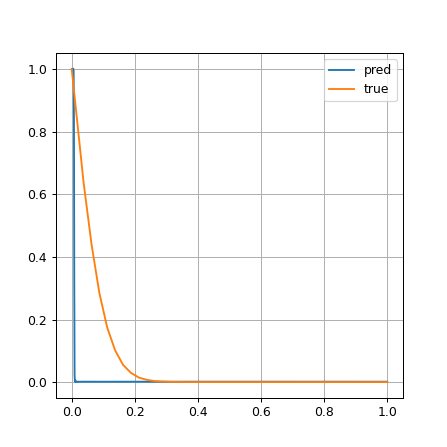

In [14]:
from scipy.io import loadmat
data = loadmat("epsilon_1e-16.mat")
x_true_, u_true = data["x"], data["u"]
x_true = np.zeros_like(u_true)
x_true[0] = 0; x_true[-1] = 1
x_true[1:-1] = x_true_

f, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.plot(x_test, f_int_preds[-1], label = "pred")
ax.plot(x_true, u_true, label = "true")
ax.legend()
ax.grid()
plt.show()

In [ ]:
# from matplotlib import animation
# %matplotlib notebook

# fig, ax = plt.subplots(2, 3, figsize = (15, 10))
# lines = []
# for i in range(2):
# 	for j in range(3):
# 		line, = ax[i][j].plot([], [], lw = 1.5, label = "pred")
# 		lines.append(line)
# 		ax[i][j].set_xlim([-1, 1])
# 		ax[i][j].set_ylim([-5, 5])
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# ax[0][0].set_ylim([0.9, 2.1])
# ax[1][0].set_ylim([-0.1, 1.0])
    
# def init():
# 	for line in lines:
# 		line.set_data([], [])
# 	return lines

# def animate(i):
# 	u_pred, v_pred = u_preds[i], v_preds[i]
# 	du_dx_pred, dv_dx_pred = du_dx_preds[i], dv_dx_preds[i]
# 	du_dt_pred, dv_dt_pred = du_dt_preds[i], dv_dt_preds[i]
# # 	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
# 	lines[0].set_data(x_test, u_pred)
# 	ax[0][0].set_title("u, t = {:.4f}".format(t_test[i]))
# 	lines[1].set_data(x_test, du_dx_pred)
# 	ax[0][1].set_title("du_dx, t = {:.4f}".format(t_test[i]))
# 	lines[2].set_data(x_test, du_dt_pred)
# 	ax[0][2].set_title("du_dt, t = {:.4f}".format(t_test[i]))
    
# 	lines[3].set_data(x_test, v_pred)
# 	ax[1][0].set_title("v, t = {:.4f}".format(t_test[i]))
# 	lines[4].set_data(x_test, dv_dx_pred)
# 	ax[1][1].set_title("dv_dx, t = {:.4f}".format(t_test[i]))
# 	lines[5].set_data(x_test, dv_dt_pred)
# 	ax[1][2].set_title("dv_dt, t = {:.4f}".format(t_test[i]))

# 	return lines

# anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 50, blit = True)
# plt.show()

In [ ]:
# from scipy.io import loadmat
# data = loadmat("epsilon_0.49.mat")
# x_true, u_true, v_true = data["x"], data["u"], data["v"]

# f, ax = plt.subplots(1, 2, figsize = (12, 5))
# ax[0].plot(x_test, u_preds[-1], label = "pred")
# ax[0].plot(x_true, u_true, label = "true")
# ax[0].set_title("u, t = {:.2f}".format(t_test[-1]))
# ax[1].plot(x_test, v_preds[-1], label = "pred")
# ax[1].plot(x_true, v_true, label = "true")
# ax[1].set_title("v, t = {:.2f}".format(t_test[-1]))
# for i in range(2):
# 	ax[i].legend()
# 	ax[i].grid()
# plt.show()

In [ ]:
# x = jnp.linspace(*domain[:, 0], 10000).reshape((-1, 1))
# t = jnp.zeros_like(x)
# xt = jnp.hstack([x, t])


# # direct_params_ = direct_params
# direct_params_ = get_params(opt_state)
# duv_dxt = jacobian(direct_params_, xt)
# du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
# du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
# duv_dxxtt = hessian(direct_params_, xt)
# du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
# uv = model(direct_params_, xt)
# u, v = uv[:, 0:1], uv[:, 1:2]
# loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
# loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

# du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
# du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
# u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
# du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
# dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
# loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
# loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

# %matplotlib inline
# plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams["text.usetex"] = True

# f, ax = plt.subplots(2, 5, figsize = (20, 10))
# i, j = 0, 0
# ax[i][j].plot(x, du_dt, label = "pred")
# ax[i][j].plot(x, du0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
# i = 1
# ax[i][j].plot(x, dv_dt, label = "pred")
# ax[i][j].plot(x, dv0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dx, label = "pred")
# ax[i][j].plot(x, du0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
# i = 1
# ax[i][j].plot(x, dv_dx, label = "pred")
# ax[i][j].plot(x, dv0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dxx, label = "pred")
# ax[i][j].plot(x, du0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
# i = 1
# ax[i][j].plot(x, dv_dxx, label = "pred")
# ax[i][j].plot(x, dv0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
# i, j = 0, j+1
# ax[i][j].plot(x, u, label = "pred")
# ax[i][j].plot(x, u0, label = "true")
# ax[i][j].set_title(r"$u$")
# i = 1
# ax[i][j].plot(x, v, label = "pred")
# ax[i][j].plot(x, v0, label = "true")
# ax[i][j].set_title(r"$v$")
# i, j = 0, j+1
# ax[i][j].plot(x, loss_c1, label = "pred")
# ax[i][j].plot(x, loss_c10, label = "true")
# ax[i][j].set_title(r"loss c1")
# i = 1
# ax[i][j].plot(x, loss_c2, label = "pred")
# ax[i][j].plot(x, loss_c20, label = "true")
# ax[i][j].set_title(r"loss c2")

# for i in range(2):
# 	for j in range(5):
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# plt.show()

In [ ]:
get_params(opt_state)